In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab04.ipynb")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from pathlib import Path
%load_ext sql

# Lab 4: SQL 
This notebook is an introduction to SQL. We will be working with a two SQLite datasets: the International Debt Database collected by [the World Bank](https://www.worldbank.org/en/programs/debt-statistics/ids#standard), and a dataset of each country's [PPP](https://www.investopedia.com/updates/purchasing-power-parity-ppp/) (purchasing power parity), as collected by the Organisation for Economic Co-operation and Development (OECD; dataset source [here](https://data.oecd.org/gdp/gross-domestic-product-gdp.htm#indicator-chart)). We are going to explore several questions, some of which include:

- How much debt do various countries have?
- What are the different debt indicators?
- How can we calculate the debt ratio for each country?
- How can we translate between SQL and Pandas queries?

We will be working with these datasets via [SQL magic functions](https://jupyter-tutorial.readthedocs.io/en/stable/data-processing/postgresql/ipython-sql.html), more information included in part 1. 

### Learning Objectives: 
- Practice basic SQL queries
- Translate between SQL queries and Pandas methods

## Setup

Please just run the cells below to set up your SQL database and the autograder.

In [3]:
# These lines specify the location of our database file
dbfile = 'international_debt_3.db'
tmpdb = Path('data') / dbfile

# Specify the database connection path (in this case, a sqlite database in a file)
sqlite_conn = 'sqlite:///' + str(tmpdb)

In [4]:
# Run this cell to connect to database
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

In [5]:
%sql engine

In Jupyter Notebooks, a [cell 'magic' command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) is a special command that is preceded by two percentage signs (%%). Cell magics operate on entire cells and are used to change the behavior of the entire cell. They are not part of the Python language itself but are specific to the Jupyter environment. They help us do a lot of cool things, like run SQL commands directly within Jupyter! Using cell magic, let's load in the database and see which datasets we have access to.

In [6]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'sqlite:///data/international_debt_3.db'

type,name,tbl_name,rootpage,sql
table,debt,debt,2,"CREATE TABLE debt (country_name CHAR (50), country_code CHAR (50), indicator_name TEXT, indicator_code TEXT, debt NUMERIC)"
table,gdp_2022,gdp_2022,117,"CREATE TABLE gdp_2022( LOCATION, MEASURE, FREQUENCY, TIME, Value, ""Flag Codes"")"


From running the above cell, we see that our database has two tables, `debt` and `gdp_2022`, both of which we will explore further in this notebook.

---
## Part 1: Exploring the Data

We can read in data from the SQL database using SQL queries. As a very simple example, the cell below reads in the first 100 rows from the `debt` table. Despite us reading in 100 rows, the restrictions of this Jupyter notebook only display 10 at a time.


In [7]:
%%sql
SELECT *
FROM debt
LIMIT 100

Running query in 'sqlite:///data/international_debt_3.db'

country_name,country_code,indicator_name,indicator_code,debt
Afghanistan,AFG,"Disbursements on external debt, long-term (DIS, current US$)",DT.DIS.DLXF.CD,72894453.7
Afghanistan,AFG,"Interest payments on external debt, long-term (INT, current US$)",DT.INT.DLXF.CD,53239440.1
Afghanistan,AFG,"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD,61739336.9
Afghanistan,AFG,"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD,49114729.4
Afghanistan,AFG,"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD,39903620.1
Afghanistan,AFG,"PPG, multilateral (AMT, current US$)",DT.AMT.MLAT.CD,39107845
Afghanistan,AFG,"PPG, multilateral (DIS, current US$)",DT.DIS.MLAT.CD,23779724.3
Afghanistan,AFG,"PPG, multilateral (INT, current US$)",DT.INT.MLAT.CD,13335820
Afghanistan,AFG,"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD,100847181.9
Afghanistan,AFG,"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD,72894453.7


<div class="alert alert-info">

**Note:** SQL is designed for very fast and efficient use with extremely large databases. However, if you try to access all the rows at once, SQL won't prevent them from being returned. This could crash your computer as you may not have enough space to accommodate such a large output. Please always `LIMIT` your SQL queries unless you are 100% sure the output will not be excessively large. 

While the datasets in this lab are small enough to not crash your computer, it is still generally a good practice to limit your outputs while you're brainstorming different chunks of code. However, please do not limit your final answer as that may cause the autograder to not work.

</div>

Notice how the output of the SQL command is not a pandas DataFrame. Instead, it's a SQL [Result Set](https://docs.oracle.com/cd/E17952_01/x-devapi-userguide-en/working-with-sql-result-sets.html). You can easily convert it to a dataframe by storing the ResultSet object and calling `.DataFrame()` on it. To store the ResultSet object, just add `res_(the_name) <<` after your `%%sql` call. By doing this, `res_(the_name)` will be assigned to a variable containing the actual ResultSet output, which you can convert to a dataframe easily. An example is shown below.

In [8]:
%%sql res_example1 <<
/* hi */
SELECT *
FROM debt

Running query in 'sqlite:///data/international_debt_3.db'

In [9]:
res_example1

country_name,country_code,indicator_name,indicator_code,debt
Afghanistan,AFG,"Disbursements on external debt, long-term (DIS, current US$)",DT.DIS.DLXF.CD,72894453.7
Afghanistan,AFG,"Interest payments on external debt, long-term (INT, current US$)",DT.INT.DLXF.CD,53239440.1
Afghanistan,AFG,"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD,61739336.9
Afghanistan,AFG,"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD,49114729.4
Afghanistan,AFG,"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD,39903620.1
Afghanistan,AFG,"PPG, multilateral (AMT, current US$)",DT.AMT.MLAT.CD,39107845
Afghanistan,AFG,"PPG, multilateral (DIS, current US$)",DT.DIS.MLAT.CD,23779724.3
Afghanistan,AFG,"PPG, multilateral (INT, current US$)",DT.INT.MLAT.CD,13335820
Afghanistan,AFG,"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD,100847181.9
Afghanistan,AFG,"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD,72894453.7


In [10]:
res_example1.DataFrame()

,country_name,country_code,indicator_name,indicator_code,debt
0,Afghanistan,AFG,"Disbursements on external debt, long-term (DIS...",DT.DIS.DLXF.CD,72894453.7
1,Afghanistan,AFG,"Interest payments on external debt, long-term ...",DT.INT.DLXF.CD,53239440.1
2,Afghanistan,AFG,"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD,61739336.9
3,Afghanistan,AFG,"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD,49114729.4
4,Afghanistan,AFG,"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD,39903620.1
...,...,...,...,...,...
2352,Zimbabwe,ZWE,"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD,98492119.9
2353,Zimbabwe,ZWE,"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD,44396033.7
2354,Zimbabwe,ZWE,"PPG, official creditors (INT, current US$)",DT.INT.OFFT.CD,15761660.0
2355,Zimbabwe,ZWE,"Principal repayments on external debt, long-te...",DT.AMT.DLXF.CD,461632253.7


Our autograder does something similar to access your SQL outputs, please **never** edit the first line of your answer.

**Question 1.1:** Write a query to select all values for Afghanistan from the `debt` table.

In [11]:
%%sql res_q1_1 <<
SELECT * 
FROM debt 
WHERE country_name LIKE 'Afghanistan'

Running query in 'sqlite:///data/international_debt_3.db'

In [12]:
grader.check("q1_1")

q1_1 results: All test cases passed!

**Question 1.2:** How many distinct countries are there in the dataset? Write a query that can help us answer this. Your query output should look like the following:

| total_distinct_countries |
| --- |
| XXX |

Hint: remember to rename the column. 

In [13]:
%%sql res_q1_2 <<
SELECT COUNT(DISTINCT country_name) AS total_distinct_countries
FROM debt

Running query in 'sqlite:///data/international_debt_3.db'

In [14]:
grader.check("q1_2")

q1_2 results: All test cases passed!

**Question 1.3:** What are the distinct debt indicators? Write a query that can help us answer this. And then order the result by the indicators in an alphabetical order. Your query output should look like the following:

| | distinct_debt_indicators |
| --- | --- |
| 0 | DT.AMT.BLAT.CD |
| 1 | DT.AMT.DLXF.CD |
| 2 | ... (rows omitted) |

Hint: remember to rename the column. 

In [15]:
%%sql res_q1_3 <<
SELECT DISTINCT indicator_code AS distinct_debt_indicators
FROM debt

Running query in 'sqlite:///data/international_debt_3.db'

In [16]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4:** What is the total amount of debt for each country? Write a query that can help us answer this. And then order the result by the country name in an alphabetical order. Your query output should look like the following:

| | country_name | total_debt |
| --- | --- | --- |
| 0 | Afghanistan | XXX |
| 1 | Albania | XXX |
| 2 |  | ... (rows omitted) |

Hint: Assume that the total amount of debt is the sum of debt from all categories in the table. Remember to rename the column. 

In [17]:
%%sql res_q1_4 <<
SELECT country_name, SUM(debt) AS total_debt
FROM debt
GROUP BY country_name

Running query in 'sqlite:///data/international_debt_3.db'

In [18]:
grader.check("q1_4")

q1_4 results: All test cases passed!

**Question 1.5:** Which are the countries with largest debt? Similar to the last question, but order by the total amount of debt this time in a descending order. Break the tie (if any) by country name in an alphabetical order. Your query output should look like the following:

| | country_name | total_debt |
| --- | --- | --- |
| 0 | China | XXX |
| 1 | Brazil | XXX |
| 2 |  | ... (rows omitted) |

Hint: Assume that the total amount of debt is the sum of debt from all categories in the table. Remember to rename the column. 

In [19]:
%%sql res_q1_5 <<
SELECT country_name, SUM(debt) AS total_debt
FROM debt
GROUP BY country_name
ORDER BY total_debt DESC

Running query in 'sqlite:///data/international_debt_3.db'

In [20]:
grader.check("q1_5")

q1_5 results: All test cases passed!

**Question 1.6:** What are the various types of debts and their totals for the developing countries in our data? Write a query that can help us answer this. Order by the total amount of debt for each category in a descending order. Your query output should look like the following:

| | indicator_name | total_debt |
| --- | --- | --- |
| 0 | Principal repayments on external debt, long-te... | XXX |
| 1 | Principal repayments on external debt, private... | XXX |
| 2 |  | ... (rows omitted) |

Hint: remember to rename the column. 

In [21]:
%%sql res_q1_6 <<
SELECT indicator_name, SUM(debt) AS total_debt
FROM debt
GROUP BY indicator_name
ORDER BY total_debt DESC

Running query in 'sqlite:///data/international_debt_3.db'

In [22]:
grader.check("q1_6")

q1_6 results: All test cases passed!

**Question 1.7:** Now we want to investigate further about the two countries with the largest debt--China and Brazil. Write a query that select only China and Brazil. Order by the debt category code in an alphabetical order, and break tie by country name in an alphabetical order. Your query output should look like the following:

| | country_name | country_code	| indicator_name | indicator_code | debt |
| --- | --- | --- | --- | --- | --- |
| 0 | Brazil | BRA | PPG, bilateral (AMT, current US\$) | DT.AMT.BLAT.CD | XXX |
| 1 | China | CHN | PPG, bilateral (AMT, current US\$) | DT.AMT.BLAT.CD | XXX |
| 2 |  |  |  |  | ... (rows omitted) |

In [23]:
%%sql res_q1_7 <<
SELECT *
FROM debt
WHERE country_code LIKE 'BRA' OR country_code LIKE 'CHN'
ORDER BY indicator_code ASC, country_name ASC


Running query in 'sqlite:///data/international_debt_3.db'

In [24]:
grader.check("q1_7")

q1_7 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.8:** Look at the result above. Do you notice any big difference in the amount of debt in some categories between Brazil and China?

To look into this I will start by plotting the amount of debt (`indicator_code` starting with `DT.AMT`) to get a view of the differences – see the full overview of the World Bank Metadata Glossary [here](https://databank.worldbank.org/metadataglossary/all/series)

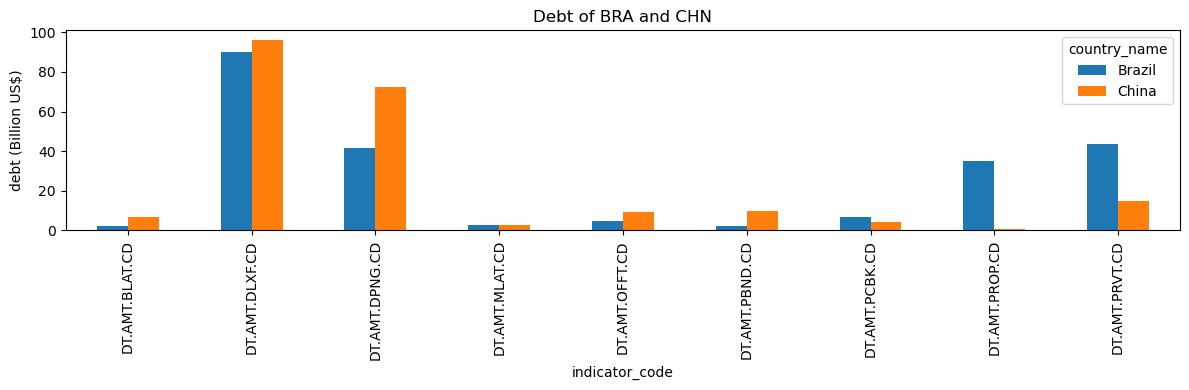

In [25]:
BRA_CHN = res_q1_7.DataFrame()
BRA_CHN = BRA_CHN[BRA_CHN['indicator_code'].str.startswith('DT.AMT')]
BRA_CHN['debt'] = BRA_CHN['debt']/1000000000
fig, ax = plt.subplots(figsize=(12, 4))
BRA_CHN.pivot(columns='country_name', index='indicator_code', values='debt').plot(kind='bar', ax=ax)
ax.set_ylabel('debt (Billion US$)')
ax.set_title('Debt of BRA and CHN')
plt.tight_layout()
plt.show()

In the plot above I notice 3 categories specifically where the debt levels of the two countries differ drastically. Those are _Principal repayments on external debt, private nonguaranteed (PNG)_, _PPG, other private creditors_, and _PPG, private creditors_. For the first category, China's debt is more than US$ 30 billion greater than that of Brazil while Brazil leads in the two other. For the two latter the debt of Brazil is around US$ 30 billion greater than that of China.

In [26]:
display(BRA_CHN[(BRA_CHN['indicator_code']=='DT.AMT.DPNG.CD')|(BRA_CHN['indicator_code']=='DT.AMT.PROP.CD')|(BRA_CHN['indicator_code']=='DT.AMT.PRVT.CD')][['country_name','indicator_name','indicator_code','debt']])

,country_name,indicator_name,indicator_code,debt
4,Brazil,"Principal repayments on external debt, private...",DT.AMT.DPNG.CD,41.831444
5,China,"Principal repayments on external debt, private...",DT.AMT.DPNG.CD,72.392986
14,Brazil,"PPG, other private creditors (AMT, current US$)",DT.AMT.PROP.CD,35.119004
15,China,"PPG, other private creditors (AMT, current US$)",DT.AMT.PROP.CD,0.796544
16,Brazil,"PPG, private creditors (AMT, current US$)",DT.AMT.PRVT.CD,43.598697
17,China,"PPG, private creditors (AMT, current US$)",DT.AMT.PRVT.CD,14.677464


<!-- END QUESTION -->

---
## Part 2: Using multiple tables

In this part, we will join our two SQL tables and do operations with them. First, let's take a look at the `gdp_2022` table.

In [27]:
%%sql
SELECT *
FROM gdp_2022
LIMIT 100

Running query in 'sqlite:///data/international_debt_3.db'

LOCATION,MEASURE,FREQUENCY,TIME,Value,Flag Codes
AUS,MLN_USD,A,2022,1804621.816,
AUT,MLN_USD,A,2022,613714.889,
BEL,MLN_USD,A,2022,765169.283,P
CAN,MLN_USD,A,2022,2271469.345,
CZE,MLN_USD,A,2022,525014.413,
DNK,MLN_USD,A,2022,442119.714,
FIN,MLN_USD,A,2022,330422.255,
FRA,MLN_USD,A,2022,3764758.779,P
DEU,MLN_USD,A,2022,5323008.116,P
GRC,MLN_USD,A,2022,386578.919,P


**Question 2.1:** Looking at the `gdp_2022` table, it appears the the `LOCATION` column contains the three digit country code for each country, similar to the `country_code` column in the `debt` table. Use this information to perform a simple join on both tables, only keeping rows where there are no missing values in either table.

In [28]:
%%sql res_q2_1 <<
SELECT *
FROM debt
INNER JOIN gdp_2022
ON country_code = LOCATION

Running query in 'sqlite:///data/international_debt_3.db'

In [29]:
grader.check("q2_1")

q2_1 results: All test cases passed!

This table has a slight misnomer. While it is named `gdp_2022`, it actually doesn't have any GDP information at all. Instead, it contains the total PPP for each country (in millions of dollars) in 2022 in the `Value` column (read more about the difference [here](https://unacademy.com/content/railway-exam/study-material/static-gk/differentiate-between-gdp-and-ppp/#:~:text=GDP%20can%20be%20used%20as,country%20boundaries%20annually%20or%20quarterly)).

**Question 2.2:** Combining data from the two tables, generate a new table that has each country's name, total debt (across all indicators), ppp in dollars (not in millions of dollars) and the year in which these values were measured (which is always 2022). The first 5 rows of your output should look like the sample dataframe below.

In [30]:
examp_2_2_data = {
    'country': ['Bulgaria', 'China', 'Colombia', 'Costa Rica', 'Indonesia'],
    'debt': [6.369102e9, 2.857935e11, 4.543012e10, 8.616331e9, 1.134357e11],
    'ppp': [2.202952e11, 3.009070e13, 1.051418e12, 1.291200e11, 3.969883e12],
    'year': [2022, 2022, 2022, 2022, 2022]
}

df_2_2 = pd.DataFrame(examp_2_2_data)
df_2_2

,country,debt,ppp,year
0,Bulgaria,6.369102e+09,2.202952e+11,2022
1,China,2.857935e+11,3.009070e+13,2022
2,Colombia,4.543012e+10,1.051418e+12,2022
3,Costa Rica,8.616331e+09,1.291200e+11,2022
4,Indonesia,1.134357e+11,3.969883e+12,2022


In [31]:
%%sql res_q2_2 <<
SELECT country_name AS country, SUM(debt) AS debt, Value*1000000 AS ppp, TIME AS year
FROM (
    SELECT *
    FROM debt
    INNER JOIN gdp_2022
    ON country_code = LOCATION
)
GROUP BY country

Running query in 'sqlite:///data/international_debt_3.db'

In [32]:
grader.check("q2_2")

q2_2 results: All test cases passed!

The `debt` table has 124 different country codes, while the `gdp_2022` table has 50 different country codes. Despite that, both tables only have 10 overlapping countries. This is unfortunate, but it is the only data we have - welcome to real world data science!

**Question 2.3:** Since we have all the relevant data, we might as well calculate the [debt ratio](https://worldpopulationreview.com/country-rankings/debt-to-gdp-ratio-by-country) for each country. Your output for this question should be very similar to your output for 2.2, with the only new column being called `debtRatio` and representing the debt ratio for each country. For the sake of clarity, only show the first 3 decimal places of each country's debt ratio.

*Note:* As we're comparing debt with PPP rather than with GDP, we're calculating the Debt-to-PPP ratio rather than Debt-to-GDP.

In [33]:
%%sql res_q2_3 <<
SELECT country_name AS country, SUM(debt) AS debt, Value*1000000 AS ppp, TIME AS year, ROUND(SUM(debt)/(Value*1000000),3) AS debtRatio
FROM (
    SELECT *
    FROM debt
    INNER JOIN gdp_2022
    ON country_code = LOCATION
)
GROUP BY country

Running query in 'sqlite:///data/international_debt_3.db'

In [34]:
grader.check("q2_3")

q2_3 results: All test cases passed!

**Question 2.4:** As we saw above, there are very few countries with data across both tables. To mitigate this, create a table which has information on the debt for as many countries as possible, regardless on whether or not we also have data on their ppp. Don't include any countries for which you do not have information on the debt. This table should have the same columns as the output for question 2.2.

In [35]:
%%sql res_q2_4 <<
SELECT country_name AS country, SUM(debt) AS debt, Value*1000000 AS ppp, TIME AS year
FROM (
    SELECT *
    FROM debt
    LEFT JOIN gdp_2022
    ON country_code = LOCATION
)
GROUP BY country


Running query in 'sqlite:///data/international_debt_3.db'

In [36]:
grader.check("q2_4")

q2_4 results: All test cases passed!

**Question 2.5:** Filter the table from question 2.4 to only output countries with a total debt greater than 10 billion dollars.

Right answer correctly summing debt

In [37]:
%%sql res_q2_5 <<
SELECT *
FROM(
    SELECT country_name AS country, SUM(debt) AS debt, Value*1000000 AS ppp, TIME AS year
    FROM (
        SELECT *
        FROM debt
        LEFT JOIN gdp_2022
        ON country_code = LOCATION
    )
GROUP BY country
)
WHERE debt > 10000000000

Running query in 'sqlite:///data/international_debt_3.db'

Wrong answer (but correct according to gradescope) not summing but just taking first number in debt

In [38]:
%%sql res_q2_5 <<
SELECT *
FROM(
    SELECT country_name AS country, debt, Value*1000000 AS ppp, TIME AS year
    FROM (
        SELECT *
        FROM debt
        LEFT JOIN gdp_2022
        ON country_code = LOCATION
    )
GROUP BY country
)
WHERE debt > 10000000000


Running query in 'sqlite:///data/international_debt_3.db'

In [39]:
grader.check("q2_5")

q2_5 results: All test cases passed!

Looking at the output, we can see that the `debt` table also contains some regions which aren't exactly countries. If we did our EDA better, we would've ideally caught these rows earlier and appropriately dealt with them.

**Question 2.6:** Let's take a slightly more sophisticated approach. Let's add in a column `Warning Level` to the table from question 2.4, which says `safe` if the debt level is less than 100 million dollars, `warning` if the debt level is between 100 million and 10 billion dollars, and `danger` if the debt level is greater than 10 billion dollars.

In [40]:
%%sql res_q2_6 <<
SELECT country_name AS country, SUM(debt) AS debt, Value*1000000 AS ppp, TIME AS year, CASE
        WHEN SUM(debt)<100000000 THEN 'safe'
        WHEN SUM(debt)<10000000000 THEN 'warning'
        ELSE 'danger'
    END AS 'Warning Level'
FROM (
    SELECT *
    FROM debt
    LEFT JOIN gdp_2022
    ON country_code = LOCATION
)
GROUP BY country

Running query in 'sqlite:///data/international_debt_3.db'

In [41]:
%%sql res_q2_6 <<
SELECT country_name AS country, debt, Value*1000000 AS ppp, TIME AS year, CASE
        WHEN debt<100000000 THEN 'safe'
        WHEN debt<10000000000 THEN 'warning'
        ELSE 'danger'
    END AS 'Warning Level'
FROM (
    SELECT *
    FROM debt
    LEFT JOIN gdp_2022
    ON country_code = LOCATION
)
GROUP BY country

Running query in 'sqlite:///data/international_debt_3.db'

In [42]:
grader.check("q2_6")

q2_6 results: All test cases passed!

---
## Part 3: Translating SQL queries
In this part, we will do some simple exercise to find equivalent commands in SQL and Pandas. 

In this part, we will have two tables or dataframes: `farm` and `shop`. You may have already seen them in the discussion sections!

The `farm` table:

| | crop | price | type | is_red |
| --- | --- | --- | --- | --- |
| 0 | Starfruit | 750 | Fruit | False |
| 1 | Sweet Gem Berry | 3000 | Fruit | True |
| 2 | Red Cabbage | 260 | Vegetable | True |
| 3 | Parsnip | 35 | Vegetable | True |
| 4 | Pumpkin | 320 | Vegetable | False |

The `shop` table:

| | type | on_sale |
| --- | --- | --- |
| 0 | Fruit | True |
| 1 | Vegetable | False |
| 2 | Egg | False |
| 3 | Fish | False |

**Question 3.1:** Which of the following SQL query or queries are logically equivalent to the following Pandas query?

```python
farm.merge(shop, how="inner", on="type")
```

a.
``` mysql
SELECT * FROM farm, shop
WHERE type = type;
``` 
b.
``` mysql
SELECT * FROM farm, shop 
WHERE farm.type = shop.type;
``` 
c.
``` mysql
SELECT * FROM farm
INNER JOIN shop
WHERE farm.type = shop.type;
``` 
d.
``` mysql
SELECT * FROM farm
INNER JOIN shop
ON farm.type = shop.type;
``` 

Assign an array of letters corresponding to your answer to `q2_1` below. For example, `q2_1 = np.array(['a', 'b', 'c', 'd'])`.

In [43]:
q3_1 = np.array(['b','d'])

In [44]:
grader.check("q3_1")

q3_1 results: All test cases passed!

**Question 3.2:** Which of the following Pandas command or commands are logically equivalent to the following SQL queries query?

``` mysql
SELECT type, AVG(price)
FROM farm
GROUP BY type;

``` 

a.
``` python
farm["price"].mean()
``` 
b.
``` python
farm.groupby(["type", "price"]).mean()
```  
c.
``` python
farm.groupby("price")[["type"]].mean()
``` 
d.
``` python
farm.groupby("type")[["price"]].mean()
``` 

Assign an array of letters corresponding to your answer to `q2_2` below. For example, `q2_2 = np.array(['a', 'b', 'c', 'd'])`.

In [45]:
q3_2 = np.array(['d'])

In [46]:
grader.check("q3_2")

q3_2 results: All test cases passed!

---
## Feedback

**Question 4:** Please fill out this short [feedback form](https://forms.gle/CUMuTDkgZR56zUWx8) to let us know your thoughts about this lab! We really appreciate your opinions and feedback! At the end of the Google form, you should see a codeword. Assign the codeword to the variable `codeword` below. 

In [47]:
codeword = 'payment'

In [48]:
grader.check("q4")

q4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [49]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

/Users/johanoelgaard/anaconda3/lib/python3.11/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (3.1.11.1).
Your version must be at least (1.12.1) but less than (3.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()


Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_4 results: All test cases passed!

    q1_5 results: All test cases passed!

    q1_6 results: All test cases passed!

    q1_7 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_2 results: All test cases passed!

    q2_3 results: All test cases passed!

    q2_4 results: All test cases passed!

    q2_5 results: All test cases passed!

    q2_6 results: All test cases passed!

    q3_1 results: All test cases passed!

    q3_2 results: All test cases passed!

    q4 results: All test cases passed!
